<a href="https://colab.research.google.com/github/sujeongzoe/KDT/blob/main/%5BBrain_Tumor%5Dbinary_model_layer_%ED%99%95%EC%A0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 파일명 rename
- https://data-make.tistory.com/171
- 반드시 local에서 작업해야 함.

In [ ]:
import os

def changeName(path, cName):
    i = 1
    for filename in os.listdir(path):
        print(path+filename, '=>', path+str(cName)+str(i)+'.jpg')
        os.rename(path+filename, path+str(cName)+str(i)+'.jpg')
        i += 1


In [ ]:
changeName('/Users/su221/Downloads/glioma_tumor (1)/glioma_tumor/top_glioma_tumor/','g_')

In [ ]:
changeName('/Users/su221/Downloads/pituitary_tumor (1)/top_pituitary_tumor/','p_')

## kaggl 영상 데이터 압축파일 업로드 후 압축 풀기

In [ ]:
%cd /content/drive/MyDrive/KDT_project/train/data/yes

!unzip -qq "/content/drive/MyDrive/KDT_project/train/train.zip"

/content/drive/MyDrive/KDT_project/train/data/yes


In [ ]:
%cd /content/drive/MyDrive/KDT_project/train/data/no

!unzip -qq "/content/drive/MyDrive/KDT_project/train/y_train.zip"

/content/drive/MyDrive/KDT_project/train/data/no


In [ ]:
%cd /content/drive/MyDrive/KDT_project/test/data/yes

!unzip -qq "/content/drive/MyDrive/KDT_project/test/test.zip"

/content/drive/MyDrive/KDT_project/test/data/yes


In [ ]:
%cd /content/drive/MyDrive/KDT_project/test/data/no

!unzip -qq "/content/drive/MyDrive/KDT_project/test/y_test.zip"

/content/drive/MyDrive/KDT_project/test/data/no


In [ ]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sb
sb.set_style('whitegrid')
import tensorflow as tf
from tensorflow.keras import layers,models,optimizers,preprocessing
from tensorflow.keras.layers import Conv2D,Dense,MaxPooling2D,Flatten,Dropout
from tensorflow.keras.metrics import AUC

In [ ]:
# X 정규화(/255.0) 및 y 데이터 생성(tumor('yes':1)/no_tumor('no':0))

main_dir = "/content/drive/MyDrive/KDT_project/"
classification_dirs = [("no",), ("yes",)]
resolution = 224

def load_images(root_dir_name):
    x = []
    y = []

    for label, sub_dir_names in enumerate(classification_dirs):
        for sub_dir_name in sub_dir_names:
            print(f"loading {root_dir_name} {sub_dir_name}")
            sub_dir_path = os.path.join(main_dir, root_dir_name, sub_dir_name)
            for image_name in os.listdir(sub_dir_path):
                image_path = os.path.join(sub_dir_path, image_name)
                image = preprocessing.image.load_img(image_path, target_size=(resolution, resolution))   # keras load_img
                x.append(preprocessing.image.img_to_array(image))   # 이미지를 numpy array로 변환
                y.append(label)

    x = np.array(x) / 255.0
    y = np.array(y)

    return x, y

In [ ]:
X_train, y_train = load_images("train/data")
X_test, y_test = load_images("test/data")

loading train/data no
loading train/data yes
loading test/data no
loading test/data yes


In [ ]:
# validation set 생성
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)
# stratify=y_train  :  0과 1의 비율을 동등하게 분류해주겠다.
# stratify=y_train : y_train의 클래스 비율에 맞춰 split 해달라고 요청.

print(X_train.shape)
print(X_val.shape)

(862, 224, 224, 3)
(216, 224, 224, 3)


In [ ]:
print(X_train.shape, y_train.shape,X_test.shape,y_test.shape)

(862, 224, 224, 3) (862,) (231, 224, 224, 3) (231,)


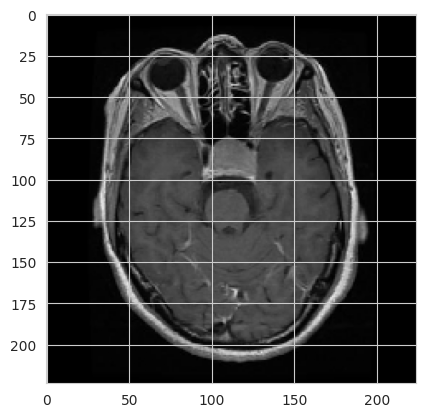

In [ ]:
plt.imshow(X_train[0])

In [ ]:
# Dropout-layer + GAP + Batch-normalization
# 모델 생성 (VGG16)
model = tf.keras.Sequential([

    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224,224,3)),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128,(3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(128,(3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(256, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(512, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(512, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(512, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(512, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(512, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(512, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.GlobalAveragePooling2D(),   # 피쳐 방향으로 다 더해준다.(flatten 했을 경우 데이터가 너무 많아 오버피팅 되는 것을 방지)
    layers.Flatten(),

    layers.Dense(4069, activation='relu'),
    layers.Dropout(0.2),

    layers.Dense(4069, activation='relu'),
    layers.Dropout(0.2),

    layers.Dense(1, activation='sigmoid')    # VGG16의 마지막 layer는 1000이었는데 이는 class가 1000개인 경우에 적용하는 코드이므로 이진 분류인 우리 모델에서는 1을 사용한다.
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 64)      36928     
                                                                 
 batch_normalization_1 (Batc  (None, 220, 220, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 64)     0         
 )                                                               
                                                        

In [ ]:
# 모델 컴파일
lr = 0.000001
model.compile(optimizer=tf.keras.optimizers.Adam(lr),
                loss='binary_crossentropy',
                metrics=['accuracy'])

# 모델 학습
from tensorflow.python.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor="val_loss", patience=10, mode="min")

history = model.fit(X_train, y_train, epochs=150, batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping])

Epoch 1/150
27/27 [==============================] - 67s 1s/step - loss: 0.6124 - accuracy: 0.6879 - val_loss: 0.6924 - val_accuracy: 0.7593
Epoch 2/150
27/27 [==============================] - 13s 485ms/step - loss: 0.5033 - accuracy: 0.7796 - val_loss: 0.6834 - val_accuracy: 0.7593
Epoch 3/150
27/27 [==============================] - 13s 478ms/step - loss: 0.4590 - accuracy: 0.8016 - val_loss: 0.6714 - val_accuracy: 0.7593
Epoch 4/150
27/27 [==============================] - 13s 467ms/step - loss: 0.4227 - accuracy: 0.8179 - val_loss: 0.6612 - val_accuracy: 0.7593
Epoch 5/150
27/27 [==============================] - 12s 461ms/step - loss: 0.3887 - accuracy: 0.8445 - val_loss: 0.6475 - val_accuracy: 0.7593
Epoch 6/150
27/27 [==============================] - 12s 463ms/step - loss: 0.3660 - accuracy: 0.8434 - val_loss: 0.6253 - val_accuracy: 0.7593
Epoch 7/150
27/27 [==============================] - 13s 469ms/step - loss: 0.3643 - accuracy: 0.8515 - val_loss: 0.6014 - val_accuracy: 0.

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

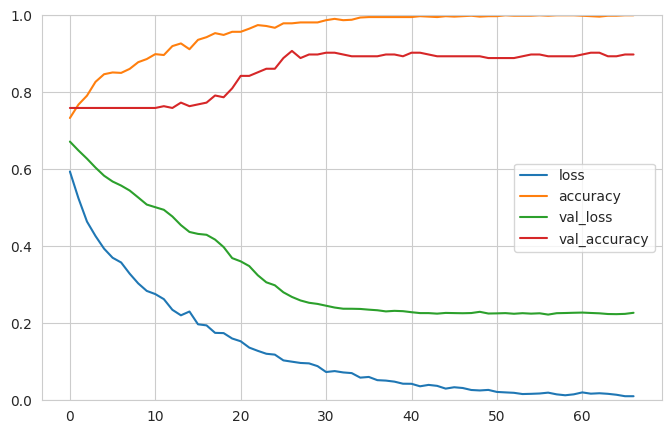

In [ ]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc
y_pred = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('AUROC: ', roc_auc)

8/8 [==============================] - 3s 346ms/step
AUROC:  0.9706790123456791


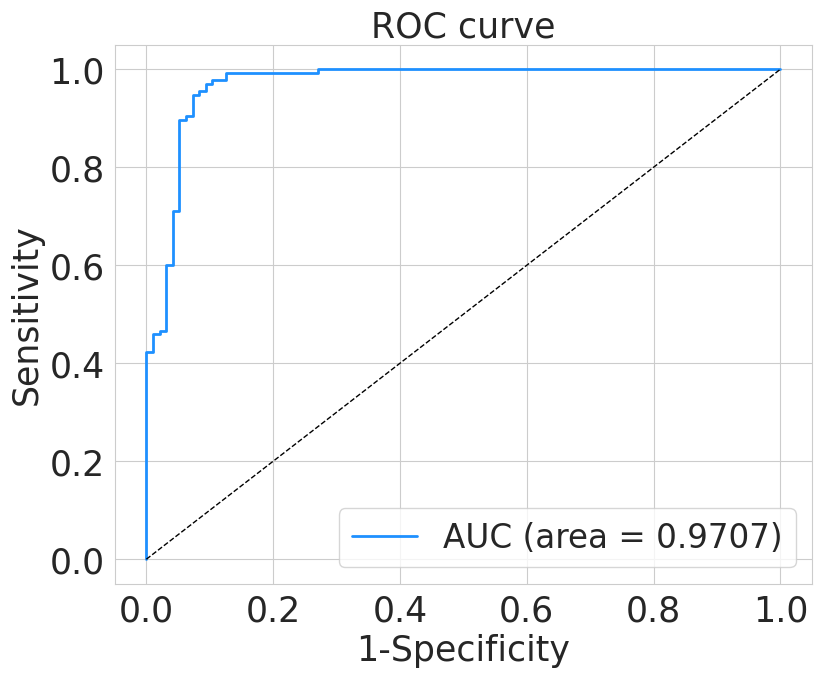

In [ ]:
plt.figure(figsize=[9,7])
plt.plot(fpr, tpr, color='dodgerblue', lw=2, label='AUC (area = %0.4f)' % roc_auc)
plt.plot([0,1], [0,1], color='black', lw=1, linestyle='--')
plt.xlim([-.05, 1.05])
plt.ylim([-.05, 1.05])
plt.xlabel('1-Specificity', fontsize=25)  # FPR
plt.ylabel('Sensitivity', fontsize=25)
plt.title('ROC curve', fontsize=25)
plt.legend(loc='lower right', fontsize=23.5)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.show()

In [ ]:
%cd /content/drive/MyDrive/KDT_project/train/total/data/yes

!unzip -qq "/content/drive/MyDrive/KDT_project/train/og.zip"

/content/drive/MyDrive/KDT_project/train/total/data/yes


In [ ]:
%cd /content/drive/MyDrive/KDT_project/train/total/data/yes

!unzip -qq "/content/drive/MyDrive/KDT_project/train/tg.zip"

/content/drive/MyDrive/KDT_project/train/total/data/yes


In [ ]:
%cd /content/drive/MyDrive/KDT_project/train/total/data/yes

!unzip -qq "/content/drive/MyDrive/KDT_project/train/p (93).zip"

/content/drive/MyDrive/KDT_project/train/total/data/yes


In [ ]:
%cd /content/drive/MyDrive/KDT_project/train/total/data/yes

!unzip -qq "/content/drive/MyDrive/KDT_project/train/m3 (98).zip"

/content/drive/MyDrive/KDT_project/train/total/data/yes


In [ ]:
%cd /content/drive/MyDrive/KDT_project/train/total/data/no

!unzip -qq "/content/drive/MyDrive/KDT_project/train/no.zip"

/content/drive/MyDrive/KDT_project/train/total/data/no


In [ ]:
%cd /content/drive/MyDrive/KDT_project/test/total/data/no

!unzip -qq "/content/drive/MyDrive/KDT_project/test/total/image(97).zip"

/content/drive/MyDrive/KDT_project/test/total/data/no


In [ ]:
%cd /content/drive/MyDrive/KDT_project/test/total/data/yes

!unzip -qq "/content/drive/MyDrive/KDT_project/test/total/g_2.zip"

/content/drive/MyDrive/KDT_project/test/total/data/yes


In [ ]:
%cd /content/drive/MyDrive/KDT_project/test/total/data/yes

!unzip -qq "/content/drive/MyDrive/KDT_project/test/total/m_113.zip"

/content/drive/MyDrive/KDT_project/test/total/data/yes


In [ ]:
%cd /content/drive/MyDrive/KDT_project/test/total/data/yes

!unzip -qq "/content/drive/MyDrive/KDT_project/test/total/p_69.zip"

/content/drive/MyDrive/KDT_project/test/total/data/yes


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sb
sb.set_style('whitegrid')
import tensorflow as tf
from tensorflow.keras import layers,models,optimizers,preprocessing
from tensorflow.keras.layers import Conv2D,Dense,MaxPooling2D,Flatten,Dropout
from tensorflow.keras.metrics import AUC

In [ ]:
main_dir = "/content/drive/MyDrive/KDT_project/"
classification_dirs = [("no",), ("yes",)]
resolution = 224

def load_images(root_dir_name):
    x = []
    y = []

    for label, sub_dir_names in enumerate(classification_dirs):
        for sub_dir_name in sub_dir_names:
            print(f"loading {root_dir_name} {sub_dir_name}")
            sub_dir_path = os.path.join(main_dir, root_dir_name, sub_dir_name)
            for image_name in os.listdir(sub_dir_path):
                image_path = os.path.join(sub_dir_path, image_name)
                image = preprocessing.image.load_img(image_path, target_size=(resolution, resolution))   # keras load_img
                x.append(preprocessing.image.img_to_array(image))   # 이미지를 numpy array로 변환
                y.append(label)

    x = np.array(x) / 255.0
    y = np.array(y)

    return x, y

In [ ]:
X_train, y_train = load_images("train/total/data")
X_test, y_test = load_images("test/total/data")

loading train/total/data no
loading train/total/data yes
loading test/total/data no
loading test/total/data yes


In [ ]:
# validation set 생성
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)
# stratify=y_train  :  0과 1의 비율을 동등하게 분류해주겠다.
# stratify=y_train : y_train의 클래스 비율에 맞춰 split 해달라고 요청.

print(X_train.shape)
print(X_val.shape)

(2296, 224, 224, 3)
(574, 224, 224, 3)


In [ ]:
print(X_train.shape, y_train.shape,X_test.shape,y_test.shape)

(2296, 224, 224, 3) (2296,) (394, 224, 224, 3) (394,)


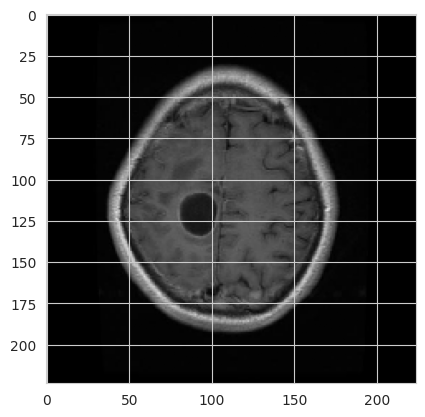

In [ ]:
plt.imshow(X_train[0])

In [ ]:
# Dropout-layer + GAP + Batch-normalization
# 모델 생성 (VGG16)
model_1 = tf.keras.Sequential([

    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224,224,3)),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128,(3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(128,(3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(256, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(512, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(512, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(512, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(512, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(512, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(512, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.GlobalAveragePooling2D(),   # 피쳐 방향으로 다 더해준다.(flatten 했을 경우 데이터가 너무 많아 오버피팅 되는 것을 방지)
    layers.Flatten(),

    layers.Dense(4069, activation='relu'),
    layers.Dropout(0.2),

    layers.Dense(4069, activation='relu'),
    layers.Dropout(0.2),

    layers.Dense(1, activation='sigmoid')
])

model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 222, 222, 64)      1792      
                                                                 
 batch_normalization_13 (Bat  (None, 222, 222, 64)     256       
 chNormalization)                                                
                                                                 
 conv2d_14 (Conv2D)          (None, 220, 220, 64)      36928     
                                                                 
 batch_normalization_14 (Bat  (None, 220, 220, 64)     256       
 chNormalization)                                                
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 110, 110, 64)     0         
 2D)                                                             
                                                      

In [ ]:
# 모델 컴파일
lr = 0.000001
model_1.compile(optimizer=tf.keras.optimizers.Adam(lr),
                loss='binary_crossentropy',
                metrics=['accuracy'])

# 모델 학습
from tensorflow.python.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor="val_loss", patience=10, mode="min")

history = model_1.fit(X_train, y_train, epochs=150, batch_size=32,
                      validation_data=(X_val, y_val),
                      callbacks=[early_stopping])

Epoch 1/150
72/72 [==============================] - 52s 554ms/step - loss: 0.5127 - accuracy: 0.7648 - val_loss: 0.6685 - val_accuracy: 0.8624
Epoch 2/150
72/72 [==============================] - 33s 456ms/step - loss: 0.3505 - accuracy: 0.8650 - val_loss: 0.5940 - val_accuracy: 0.8624
Epoch 3/150
72/72 [==============================] - 32s 446ms/step - loss: 0.3072 - accuracy: 0.8811 - val_loss: 0.4432 - val_accuracy: 0.8624
Epoch 4/150
72/72 [==============================] - 33s 457ms/step - loss: 0.2685 - accuracy: 0.8963 - val_loss: 0.4017 - val_accuracy: 0.8624
Epoch 5/150
72/72 [==============================] - 32s 446ms/step - loss: 0.2461 - accuracy: 0.9055 - val_loss: 0.4253 - val_accuracy: 0.8624
Epoch 6/150
72/72 [==============================] - 32s 451ms/step - loss: 0.2168 - accuracy: 0.9225 - val_loss: 0.4222 - val_accuracy: 0.8624
Epoch 7/150
72/72 [==============================] - 32s 447ms/step - loss: 0.2055 - accuracy: 0.9225 - val_loss: 0.4025 - val_accuracy:

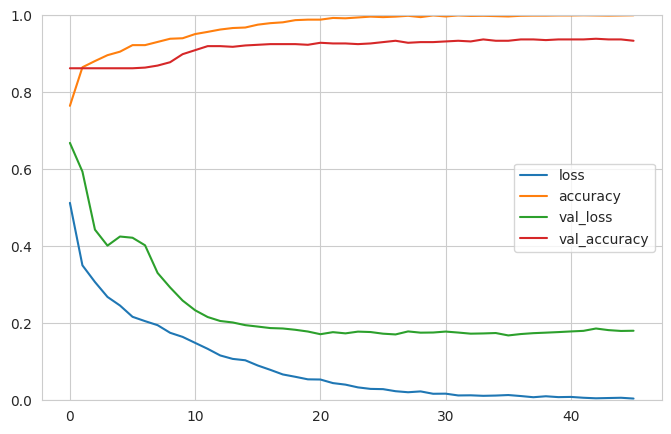

In [ ]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc
y_pred_1 = model_1.predict(X_test)
fpr_1, tpr_1, thresholds_1 = roc_curve(y_test, y_pred_1)
roc_auc_1 = auc(fpr_1, tpr_1)
print('AUROC: ', roc_auc_1)

13/13 [==============================] - 4s 285ms/step
AUROC:  0.9825012357884331


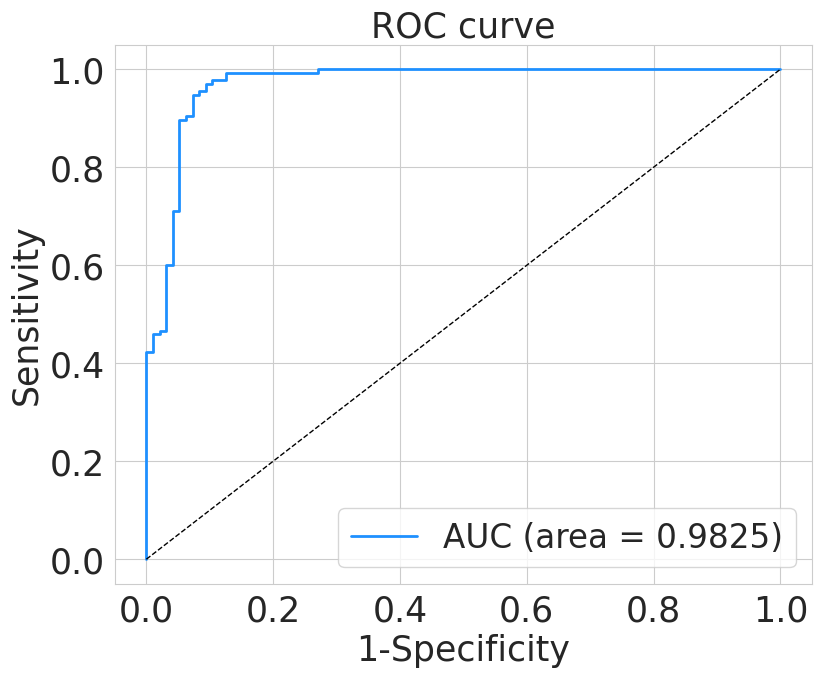

In [ ]:
plt.figure(figsize=[9,7])
plt.plot(fpr, tpr, color='dodgerblue', lw=2, label='AUC (area = %0.4f)' % roc_auc_1)
plt.plot([0,1], [0,1], color='black', lw=1, linestyle='--')
plt.xlim([-.05, 1.05])
plt.ylim([-.05, 1.05])
plt.xlabel('1-Specificity', fontsize=25)  # FPR
plt.ylabel('Sensitivity', fontsize=25)
plt.title('ROC curve', fontsize=25)
plt.legend(loc='lower right', fontsize=23.5)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.show()

In [ ]:
# Dropout-layer + GAP + Batch-normalization
# 모델 생성 (VGG16)
model_2 = tf.keras.Sequential([

    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224,224,3)),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128,(3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(128,(3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(256, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(512, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(512, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(512, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(512, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(512, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(512, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.GlobalAveragePooling2D(),   # 피쳐 방향으로 다 더해준다.(flatten 했을 경우 데이터가 너무 많아 오버피팅 되는 것을 방지)
    layers.Flatten(),

    layers.Dense(4069, activation='relu'),
    layers.Dropout(0.2),

    layers.Dense(4069, activation='relu'),
    layers.Dropout(0.2),

    layers.Dense(1, activation='sigmoid')
])

model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 64)      36928     
                                                                 
 batch_normalization_1 (Batc  (None, 220, 220, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 64)     0         
 )                                                               
                                                        

In [ ]:
# 모델 컴파일
lr = 0.00001
model_2.compile(optimizer=tf.keras.optimizers.Adam(lr),
                loss='binary_crossentropy',
                metrics=['accuracy'])

# 모델 학습
from tensorflow.python.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor="val_loss", patience=10, mode="min")

history = model_2.fit(X_train, y_train, epochs=150, batch_size=32,
                      validation_data=(X_val, y_val),
                      callbacks=[early_stopping])

Epoch 1/150
27/27 [==============================] - 62s 1s/step - loss: 0.4830 - accuracy: 0.7842 - val_loss: 0.6664 - val_accuracy: 0.7593
Epoch 2/150
27/27 [==============================] - 12s 446ms/step - loss: 0.2724 - accuracy: 0.8956 - val_loss: 0.6354 - val_accuracy: 0.7593
Epoch 3/150
27/27 [==============================] - 12s 449ms/step - loss: 0.1644 - accuracy: 0.9524 - val_loss: 0.6017 - val_accuracy: 0.7593
Epoch 4/150
27/27 [==============================] - 12s 452ms/step - loss: 0.0853 - accuracy: 0.9745 - val_loss: 0.5707 - val_accuracy: 0.7593
Epoch 5/150
27/27 [==============================] - 12s 432ms/step - loss: 0.0421 - accuracy: 0.9965 - val_loss: 0.5543 - val_accuracy: 0.7593
Epoch 6/150
27/27 [==============================] - 12s 450ms/step - loss: 0.0233 - accuracy: 1.0000 - val_loss: 0.5637 - val_accuracy: 0.7593
Epoch 7/150
27/27 [==============================] - 12s 450ms/step - loss: 0.0240 - accuracy: 0.9977 - val_loss: 0.6194 - val_accuracy: 0.

In [ ]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()